# **0. 패키지 로딩**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [2]:
np.set_printoptions(suppress = True)

# **1. 데이터 불러오기**

- 현재 매장은 `type`에 따라 5개로 구분되어있는 상태
  - typeA, typeB, typeC, typeD, typeE
  


In [8]:
## 파일 상위 경로 설정
# 본인 경로에 맞게 수정 필요(작업하는 곳에 공유 드라이브 바로가기 해두면 편함)

train_path = './data/modeling/train'
val_path = './data/modeling/val'
test_path = './data/modeling/test'

In [9]:
# 데이터 파일 경로 저장
train_files = [os.path.join(train_path, f'train{i}.csv') for i in ['A', 'B', 'C', 'D', 'E']]
val_files = [os.path.join(val_path, f'val{i}.csv') for i in ['A', 'B', 'C', 'D', 'E']]
test_files = [os.path.join(test_path, f'test{i}.csv') for i in ['A', 'B', 'C', 'D', 'E']]

# 각 파일을 데이터프레임 형태로 불러오기
train_types = [pd.read_csv(file) for file in train_files]
val_types = [pd.read_csv(file) for file in val_files]
test_types = [pd.read_csv(file) for file in test_files]

In [10]:
### 데이터 확인

print(train_files)
print(val_files)
print(test_files)

['./data/modeling/train\\trainA.csv', './data/modeling/train\\trainB.csv', './data/modeling/train\\trainC.csv', './data/modeling/train\\trainD.csv', './data/modeling/train\\trainE.csv']
['./data/modeling/val\\valA.csv', './data/modeling/val\\valB.csv', './data/modeling/val\\valC.csv', './data/modeling/val\\valD.csv', './data/modeling/val\\valE.csv']
['./data/modeling/test\\testA.csv', './data/modeling/test\\testB.csv', './data/modeling/test\\testC.csv', './data/modeling/test\\testD.csv', './data/modeling/test\\testE.csv']


# **2. 평가 지표**
- Root Mean Squared Logarithmic Error(`RMSLE`)
  - 다음과 같이 계산  
  $ \sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2} $
  - $n$: 총 인스턴스 수
  - $ \hat{y}_i$: 인스턴스 $i$에 대한 타겟의 예측값
  - $y_i$: 인스턴스 $i$에 대한 타겟의 실제값

In [11]:
from sklearn.metrics import mean_squared_log_error

### RMSLE 계산
def rmsle(y, pred):
    # 오버플로, 언더플로 방지를 위해 log1p()로 로그 변환
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    
    squared_error = (log_y - log_pred) ** 2
    
    rmsle = np.sqrt(np.mean(squared_error))
    
    return rmsle

# **3. 모델별 성능 확인을 위한 함수**

In [12]:
colors = [
    'khaki', 'teal', 'orchid', 'sandybrown', 'greenyellow', 'dodgerblue', 'rosybrown',
    'deeppink', 'salmon', 'olivedrab', 'olive', 'forestgreen',
    'royalblue', 'mediumpurple', 'gold', 'seagreen',
    'turquoise', 'steelblue', 'slategray', 'peru', 'slateblue', 'cadetblue',
    'lime', 'lavender', 'lightcoral', 'lightseagreen', 'lightskyblue', 'lightgreen',
    'lightpink', 'lightsalmon', 'lightsteelblue', 'lightyellow', 'palegreen',
]

In [13]:
## 회귀곡선 시각화
# 예측값, 실제값을 산점도로 표현

def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': actual})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(10, 8))
    plt.scatter(df.index, df['prediction'], marker='x', color='b')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

In [14]:
def model_eval(name_, pred, actual):
    global my_predictions
    global colors

    plot_predictions(name_, pred, actual)

    rmsle = np.sqrt(mean_squared_log_error(actual, pred))

    my_predictions[name_] = {'rmsle': rmsle}

    # 데이터프레임 생성
    df = pd.DataFrame(my_predictions).T
    df['model'] = df.index
    df = df.sort_values(by=['rmsle'], ascending=[True])

    # 상한, 하한 설정
    min_ = df['rmsle'].min() - 0.1
    max_ = df['rmsle'].max() + 0.1

    length = len(df)

    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['rmsle'])

    for i, v in enumerate(df['rmsle']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 0.02, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')

    plt.title('RMSLE Error', fontsize=18)
    plt.xlim(min_, max_)

    plt.show()

    print()
    print(df)

In [15]:
# 모델의 중요도 상위 10개의 피처명과 그때의 중요도 값을 Series로 반환

def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
    ftr_top10 = ftr_importances.sort_values(ascending=False)[:10]
    return ftr_top10

def visualize_ftr_importances(model):
    fig, ax = plt.subplots(figsize=(7, 5))
    fig.tight_layout()

    ftr_top10 = get_top_features(model)
    ax.set_title(model.__class__.__name__ + ' Feature Importances', size=15)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)

    sns.barplot(x=ftr_top10.values, y=ftr_top10.index, ax=ax)

# **4. 모델링**

## **🏪 Type B**

In [16]:
trainB = train_types[1]
valB = val_types[1]
testB = test_types[1]

In [17]:
trainB.head()

,sales,onpromotion,dcoilwtico,store_nbr_9,store_nbr_11,store_nbr_18,store_nbr_20,store_nbr_21,store_nbr_31,store_nbr_34,...,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,8.655214,-0.522014,-0.084655,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,5.225747,0.112980,1.514441,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,5.143831,3.024402,1.771311,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2.484907,-0.522014,-0.875071,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,2.282382,-0.522014,1.641002,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [18]:
trainB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205795 entries, 0 to 205794
Data columns (total 85 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   sales                              205795 non-null  float64
 1   onpromotion                        205795 non-null  float64
 2   dcoilwtico                         205795 non-null  float64
 3   store_nbr_9                        205795 non-null  int64  
 4   store_nbr_11                       205795 non-null  int64  
 5   store_nbr_18                       205795 non-null  int64  
 6   store_nbr_20                       205795 non-null  int64  
 7   store_nbr_21                       205795 non-null  int64  
 8   store_nbr_31                       205795 non-null  int64  
 9   store_nbr_34                       205795 non-null  int64  
 10  store_nbr_39                       205795 non-null  int64  
 11  family_AUTOMOTIVE                  2057

In [19]:
valB.head()

,sales,onpromotion,dcoilwtico,store_nbr_9,store_nbr_11,store_nbr_18,store_nbr_20,store_nbr_21,store_nbr_31,store_nbr_34,...,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,4.000,-0.522014,-0.853169,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,305.289,1.587390,-0.544259,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,517.000,-0.522014,1.319604,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1.000,-0.522014,-1.218259,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,4.000,-0.522014,-0.880229,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [20]:
testB.head()

,id,onpromotion,dcoilwtico,store_nbr_9,store_nbr_11,store_nbr_18,store_nbr_20,store_nbr_21,store_nbr_31,store_nbr_34,...,month_5,month_6,month_7,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_4
0,3000954,-0.522014,-0.620862,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3000955,-0.522014,-0.620862,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3000956,0.484427,-0.620862,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3000957,3.115180,-0.620862,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3000958,-0.522014,-0.620862,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**데이터 준비**

In [21]:
## Feature vs Target

X_train = trainB.drop('sales', axis=1)
y_train = trainB['sales']

X_val = valB.drop('sales', axis=1)
y_val = valB['sales']

In [22]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(205795, 84) (205795,)
(88198, 84) (88198,)


In [23]:
X_test = testB.drop(['id', 'family_BOOKS'], axis = 1) # train(Type B) 데이터에는 해당 정보가 x

In [24]:
X_test.shape

(4224, 84)

### **4-1. Base Model**

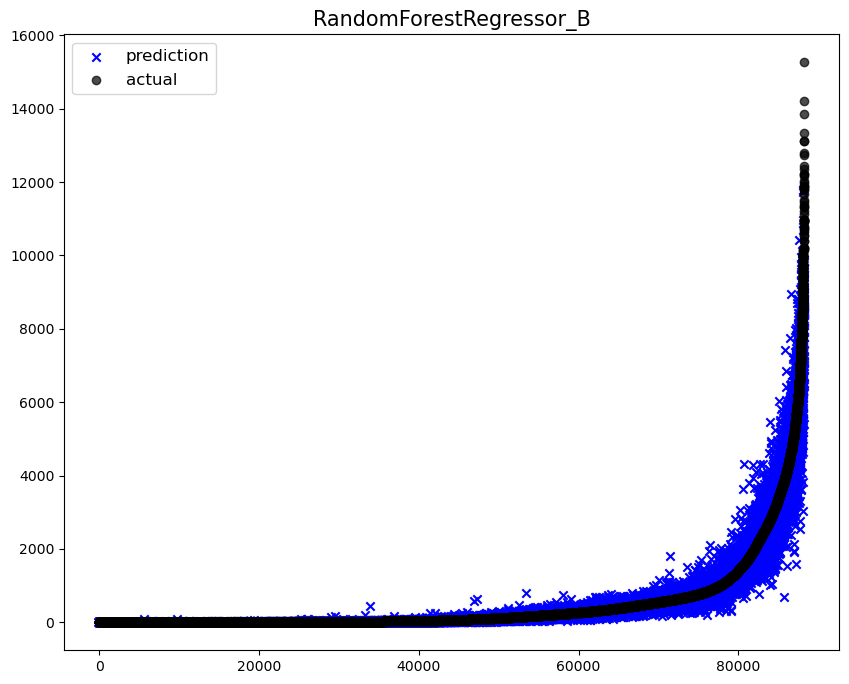

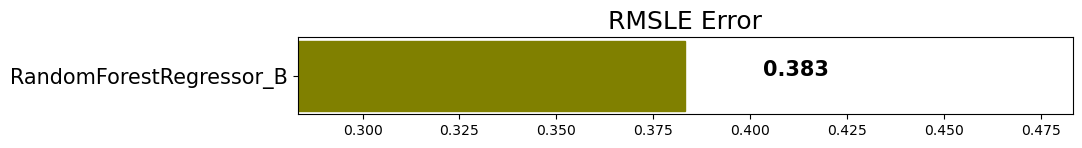


                            rmsle                    model
RandomForestRegressor_B  0.383234  RandomForestRegressor_B


In [25]:
from sklearn.ensemble import RandomForestRegressor

# 기본 모델 생성
rf_baseB = RandomForestRegressor(n_jobs = -1, random_state = 42)

my_predictions = {}  # 결과를 저장할 딕셔너리

# 모델 학습
rf_baseB.fit(X_train, y_train)

# 모델 예측
rf_predB = rf_baseB.predict(X_val)

# 로그 스케일로 예측된 예측값을 원복
original_rf_predB = np.expm1(rf_predB)

# 모델 평가 및 시각화
model_eval('RandomForestRegressor_B', original_rf_predB, y_val)

### **4-2. 하이퍼 파라미터 튜닝**


#### **HyperOpt**
- 베이지안 최적화 알고리즘을 활용하여 효율적인 하이퍼파라미터 최적화를 제공하는 파이썬 라이브러리
  - 이를 통해 사용자는 자동화된 최적화, 다양한 최적화 알고리즘 선택, 고급 최적화 알고리즘 활용 등을 통해 모델 성능을 향상시킬 수 있음
- **주요 로직**
  1. 입력 변수명과 입력값의 검색 공간 설정
  2. 목적 함수 설정
  3. 목적 함수의 반환 최솟값을 가지는 최적 입력값 유추
- 참고자료  
  [베이지안 최적화에 기반한 HyperOpt를 활용한 하이퍼 파라미터 튜닝](https://teddylee777.github.io/machine-learning/hyper-opt/)

In [ ]:
!pip install hyperopt

In [29]:
from hyperopt import hp, fmin, tpe, Trials
from hyperopt import STATUS_OK

In [30]:
## 검색 공간 설정

space = {
    'n_estimators': hp.choice('n_estimators', range(50, 201)), # 트리 개수
    'max_depth': hp.choice('max_depth', [None, 10, 20, 30]), # 트리의 최대 깊이
    'min_samples_split': hp.choice('min_samples_split', range(2, 11)), # 노드 분할을 위한 최소 샘플 수
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 11)), # 리프 노드를 위한 최소 샘플 수
    'max_features': hp.choice('max_features', [None, 'sqrt', 'log2']) # 트리 분할 시 사용할 최대 특성의 수
}

In [31]:
## 목적 함수 설정

def objective(params):
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    y_pred = np.expm1(y_pred) # 원래 스케일로 원복
    
    rmsle_val = rmsle(y_val, y_pred)
    
    return {'loss': rmsle_val, 'status': STATUS_OK}

In [32]:
## 파라미터 최적화 수행

trials = Trials()
best = fmin(fn = objective, # 목적 함수
            space = space, # 탐색 공간
            algo = tpe.suggest, # 최적화 적용 알고리즘
            max_evals = 30,  # 최대 반복 횟수
            trials = trials, # 최적값 반환
            rstate = np.random.default_rng(seed = 0)) # seed 설정
print(best)

100%|███████████████████████████████████████████████| 30/30 [58:00<00:00, 116.03s/trial, best loss: 0.3704980435650204]
{'max_depth': 0, 'max_features': 0, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 143}


- 하이퍼 파라미터 튜닝을 진행한 **model**의 성능이 더 좋다.

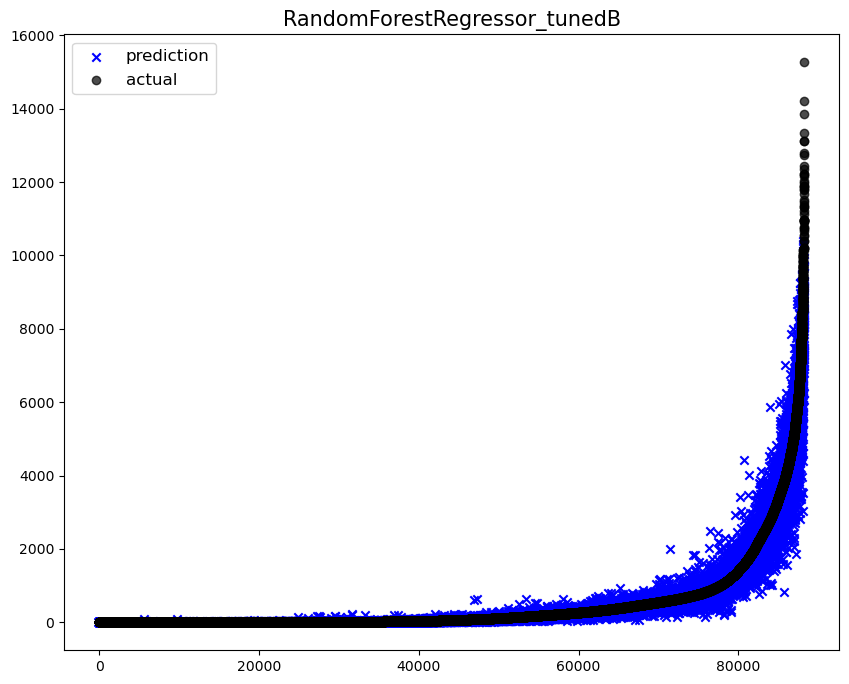

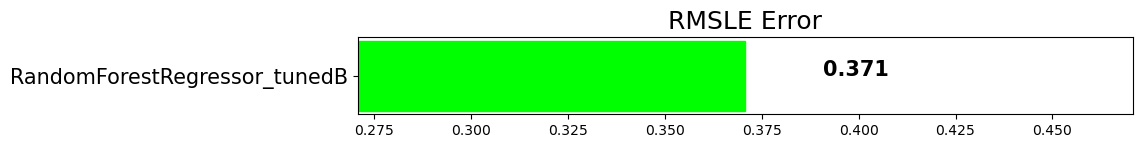


                                 rmsle                         model
RandomForestRegressor_tunedB  0.370754  RandomForestRegressor_tunedB


In [33]:
from sklearn.ensemble import RandomForestRegressor

# 최적 모델 생성
rf_tunedB = RandomForestRegressor(max_depth = None, max_features = None, min_samples_leaf = 6,
                                  min_samples_split = 6, n_estimators = 143,
                                  n_jobs = -1, random_state = 42)

my_predictions = {}  # 결과를 저장할 딕셔너리

# 모델 학습
rf_tunedB.fit(X_train, y_train)

# 모델 예측
rf_predB = rf_tunedB.predict(X_val)

# 로그 스케일로 예측된 예측값을 원복
original_rf_predB = np.expm1(rf_predB)

# 모델 평가 및 시각화
model_eval('RandomForestRegressor_tunedB', original_rf_predB, y_val)

In [34]:
### 모델 저장

import pickle
import joblib

joblib.dump(rf_tunedB, './model/modelB.pkl')

['./model/modelB.pkl']

### **4-3. 최종 예측**